Load and Cleanse the Data

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Define the labels dictionary
labels_dict = {
    0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H',
    8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O',
    15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V',
    22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'space'
}

dataset_path = 'asl_alphabet_train_copy'

if os.path.exists(dataset_path):
    print(f"Directory exists: {dataset_path}")
    categories = [d for d in sorted(os.listdir(dataset_path)) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Categories: {categories}")

    images = []
    labels = []

    image_size = (128, 128)  # Resize images to 128x128 for MobileNetV2
    for category in categories:
        category_path = os.path.join(dataset_path, category)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:  # Check if the image is loaded correctly
                image = cv2.resize(image, image_size)
                images.append(image)
                labels.append(int(category))  # Use category directly from the labels_dict

    images = np.array(images) / 255.0
    labels = to_categorical(labels, num_classes=len(labels_dict))

    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

    print(f"Training set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")
else:
    print(f"Directory does not exist: {dataset_path}")

Directory exists: asl_alphabet_train_copy
Categories: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '3', '4', '5', '6', '7', '8', '9']
Training set size: 21600, Test set size: 5400


Define and Compile the Model

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze the base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(len(labels_dict), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,927,707 (11.17 MB)

 Trainable params: 669,723 (2.55 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Data Augmentation

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X_train)

Train the Model

In [4]:
from tensorflow.keras.callbacks import EarlyStopping

# Set training parameters
batch_size = 32
epochs = 20

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1  # Set verbose to 1 to display training progress
)

Epoch 1/20


C:\Users\User\anaconda3\envs\ocv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


675/675 ━━━━━━━━━━━━━━━━━━━━ 313s 441ms/step - accuracy: 0.5341 - loss: 1.6227 - val_accuracy: 0.8824 - val_loss: 0.3647
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 338s 498ms/step - accuracy: 0.8302 - loss: 0.5238 - val_accuracy: 0.9326 - val_loss: 0.2216
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 264s 388ms/step - accuracy: 0.8631 - loss: 0.4112 - val_accuracy: 0.9283 - val_loss: 0.2212
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 227s 333ms/step - accuracy: 0.8791 - loss: 0.3660 - val_accuracy: 0.9387 - val_loss: 0.1831
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 187s 275ms/step - accuracy: 0.8929 - loss: 0.3327 - val_accuracy: 0.9324 - val_loss: 0.1950
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 156s 229ms/step - accuracy: 0.8901 - loss: 0.3286 - val_accuracy: 0.9413 - val_loss: 0.1708
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 127s 186ms/step - accuracy: 0.8981 - loss: 0.2983 - val_accuracy: 0.9483 - val_loss: 0.1486
Epoch 8/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 161s 237ms/step - accuracy: 0.8981 - loss: 0.29

Evaluate the Model

In [5]:
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]}, Test accuracy: {score[1]}")

Test loss: 0.11531487107276917, Test accuracy: 0.9611111283302307


Save the Model

In [6]:
# Save the model in HDF5 format
model.save('asl_model_mobilenetv2.h5')

Visualize Training History

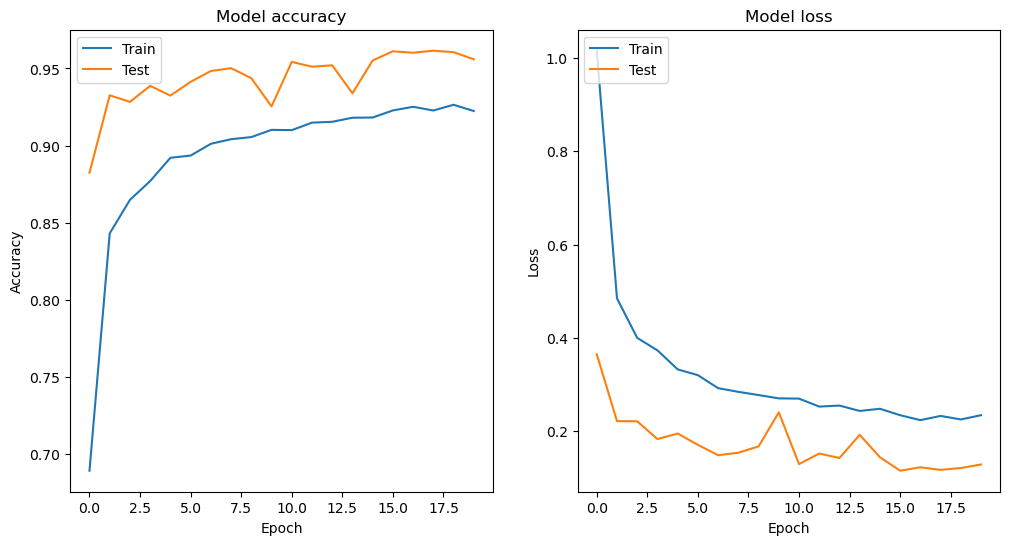

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

Generate Confusion Matrix and Classification Report

169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 89ms/step


<Figure size 1200x800 with 0 Axes>

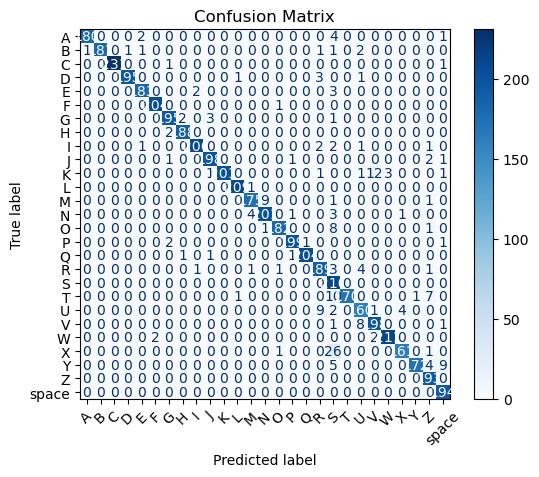

Classification Report:
               precision    recall  f1-score   support

           A       0.99      0.96      0.98       187
           B       1.00      0.96      0.98       188
           C       1.00      0.99      1.00       233
           D       0.99      0.97      0.98       200
           E       0.98      0.97      0.98       188
           F       0.99      1.00      0.99       205
           G       0.97      0.97      0.97       201
           H       0.98      0.99      0.99       190
           I       0.99      0.97      0.98       213
           J       0.98      0.98      0.98       203
           K       1.00      0.91      0.95       220
           L       0.99      1.00      0.99       210
           M       0.97      0.94      0.95       186
           N       0.95      0.96      0.95       210
           O       0.98      0.95      0.97       192
           P       0.99      0.98      0.98       203
           Q       1.00      0.99      0.99       207
   

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Map numeric predictions to labels using the labels_dict
y_pred_labels = [labels_dict[i] for i in y_pred]
y_true_labels = [labels_dict[i] for i in y_true]

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix with readable labels
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(labels_dict.values()))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=list(labels_dict.values()))
print("Classification Report:\n", report)